In [1]:
'''
This script shows how to predict main engine fuel consumption using a basic RNN
'''
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.layers import Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

C:\Users\OPT622\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def MinMaxScaler(data):
    ''' Min Max Normalization

    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]

    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]

    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [3]:
# train Parameters
seq_length = 6 #Sequence length
data_dim = 12 #input dimension
output_dim = 1 #output dimension
learning_rate = 0.01 #learning rate
iterations = 300 # iteration

# Open, High, Low, Volume, Close
xy = np.loadtxt('2017dataset_3.csv', delimiter=',') 
#xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

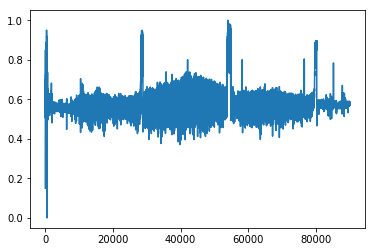

In [4]:
plt.plot(y)
plt.show()

In [5]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    #print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name = 'X-input')
Y = tf.placeholder(tf.float32, [None, 1], name = 'Y-input')

In [6]:
len(dataY)
print(trainX.shape)

(62995, 6, 12)


In [7]:




model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(seq_length,data_dim)))
#model.add(LSTM(100, input_shape=(12, 7), return_sequences=True))
model.add(LSTM(15, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(9))
model.add(Dropout(0.3)) #return_sequences=True
model.add(Dense(1)) #activation='softmax'
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(trainX, trainY, 
                    epochs=20, batch_size=70, 
                    validation_data=(testX, testY), 
                    verbose=2, shuffle=True) #shuffle=False
   

Train on 62995 samples, validate on 26999 samples
Epoch 1/20
 - 6s - loss: 0.0167 - val_loss: 8.9040e-04
Epoch 2/20
 - 5s - loss: 0.0036 - val_loss: 6.5562e-04
Epoch 3/20
 - 5s - loss: 0.0016 - val_loss: 5.3749e-04
Epoch 4/20
 - 5s - loss: 0.0014 - val_loss: 5.3094e-04
Epoch 5/20
 - 5s - loss: 0.0014 - val_loss: 9.0571e-04
Epoch 6/20
 - 5s - loss: 0.0013 - val_loss: 8.1571e-04
Epoch 7/20
 - 5s - loss: 0.0013 - val_loss: 6.3826e-04
Epoch 8/20
 - 5s - loss: 0.0012 - val_loss: 4.1181e-04
Epoch 9/20
 - 5s - loss: 0.0012 - val_loss: 5.9823e-04
Epoch 10/20
 - 5s - loss: 0.0012 - val_loss: 4.9976e-04
Epoch 11/20
 - 5s - loss: 0.0011 - val_loss: 4.7548e-04
Epoch 12/20
 - 5s - loss: 0.0011 - val_loss: 4.2066e-04
Epoch 13/20
 - 5s - loss: 0.0011 - val_loss: 4.1627e-04
Epoch 14/20
 - 5s - loss: 0.0011 - val_loss: 4.1840e-04
Epoch 15/20
 - 5s - loss: 0.0011 - val_loss: 3.8636e-04
Epoch 16/20
 - 5s - loss: 0.0011 - val_loss: 4.4505e-04
Epoch 17/20
 - 5s - loss: 0.0011 - val_loss: 5.0443e-04
Epoch 1

In [8]:
yhat1 = model.predict(testX)
testX = testX.reshape((testX.shape[0],seq_length,data_dim))
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    rmse_val = sess.run(rmse, feed_dict={
            targets: testY, predictions:yhat1})
    print("RMSE: {}".format(rmse_val))

RMSE: 0.0204730574041605


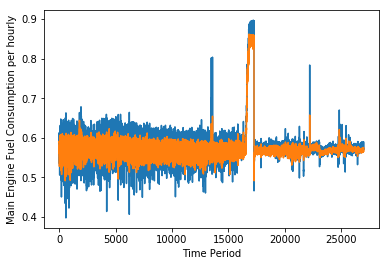

In [9]:
# Plot predictions
plt.plot(testY)
plt.plot(yhat1)
plt.xlabel("Time Period")
plt.ylabel("Main Engine Fuel Consumption per hourly")
plt.show()


In [11]:
np.savetxt('test.csv',testY,delimiter=',')
np.savetxt('pre.csv',yhat1,delimiter=',')